# Time Series Forecast Benchmark - MA vs RNN - after decomposition

There are millions of models for stock prices forecasting. We do not trust anything out there and want to evaluate which approach gives the most accurate prediction.

We want to predict the open stock prices with two days in advance because we are not brokers, we just want to have enough valuable information with enough time in advance to make the right decision.

Thus, in the current notebook, we are evaluating two traditional approaches, forecast by moving average of values in the past and recurrent neural networks trained with historical data. In both cases, the window size or sequence length used will be optimized by decreasing the RMSE between the real stock prices and the predicted ones.

Regarding the type of unit used for the recurrent neural network, we also wanted to benchmark the performance with different unit types and window sizes. We used the traditional elu recurrent units and two types of well established gated units, LSTM and GRU. For more details about the differences between unit types check [Chung et al.[2014]](https://arxiv.org/abs/1412.3555).

It is important to mention that the open stock prices were transformed to logarithmic scale and decompose by trend, seasonality and residuals with the seasonal_decompose statsmodels package with a frequency of 5 years. The "frequency" parameter optimization was done in order to assign to the residuals most of the non trendy or seasonal changes in the stock over time. Thus, when training the model and performing the forecast, the goal to predict will be only the residuals separately. The final forecast values can be calculated by calculating the exponential of the multiplication of each contribution.

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
import timeit

/Users/celsadiaz/.pyenv/versions/3.6.2/envs/ebroker/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
sp500 = pd.read_csv('../data/S_and_P_500_50_18_crisis.csv')
sp500['Date'] = pd.to_datetime(sp500['Date'])

### Decompose time series

In [3]:
def log_scale_and_decompose_time_series(data, column_to_decompose, frequency, model='multiplicative', two_sided=False):
    data_ = data.copy()
    
    # Manual extraction of the exponential trend applying the logarithm of the values
    log_column_name = 'log_' + column_to_decompose
    data_[log_column_name] = data_[column_to_decompose].apply(lambda x: np.log(x))
    
    # Decompose log_trend_open in log_trend_open_trend, log_trend_open_season, log_trend_open_resid
    result_open = seasonal_decompose(data_[log_column_name].tolist(), model=model, freq=frequency, 
                                 two_sided=two_sided)
    result_open.plot()
    plt.show()
    
    trend_column_name = 'log_' + column_to_decompose + '_trend' 
    seasonal_column_name = 'log_' + column_to_decompose + '_seasonal' 
    residual_column_name = 'log_' + column_to_decompose + '_residual' 
    data_[trend_column_name] = result_open.trend
    data_[seasonal_column_name] = result_open.seasonal
    data_[residual_column_name] = result_open.resid
    
    return data_

def exp_scale_and_recompose_time_series(series_trend, series_seasonal, series_residual):
    return np.exp(series_trend * series_seasonal * series_residual)

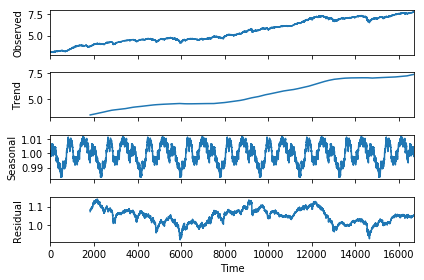

In [4]:
# Transform data to logarithmic scale and decompose the time series
frequency = 365*5
sp500_decomposed = log_scale_and_decompose_time_series(sp500, 'Open', frequency, model='multiplicative', two_sided=False)

### 1. Moving Average Forecast

In [5]:
def moving_average_forecast(series, window_size, days_in_advance):
    # Calculate moving average forecast
    ma_forecast = series.rolling(window=window_size)
    ma_forecast = ma_forecast.mean()
    
    # Calculate RMSE between prediction and data with the given days in advance
    ma_forecast_ = pd.concat([pd.Series([np.nan]*(days_in_advance-1)),
                  ma_forecast]).reset_index(drop=True)[:-(days_in_advance-1)]
    
    return math.sqrt(mean_squared_error(ma_forecast_.iloc[window_size:], series.iloc[window_size:])), ma_forecast_

In [57]:
window_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 30, 90, 365]
days_in_advance = 2
rmses_resid = []
rmses_total = []
for w_size in window_sizes:
    rmse_resid, ma_forecast = moving_average_forecast(sp500_decomposed.ix[frequency:,'log_trend_open_resid'], 
                                                w_size, days_in_advance)
    rmses_resid.append(rmse_resid)
    rmse_total, ma_forecast = moving_average_forecast(sp500_decomposed.ix[frequency:,'Open'], 
                                                w_size, days_in_advance)
    rmses_total.append(rmse_total)
    
optimization_results = pd.DataFrame({'window_size':window_sizes, 'rmse_resid':rmses_resid, 'rmse_total':rmses_total})

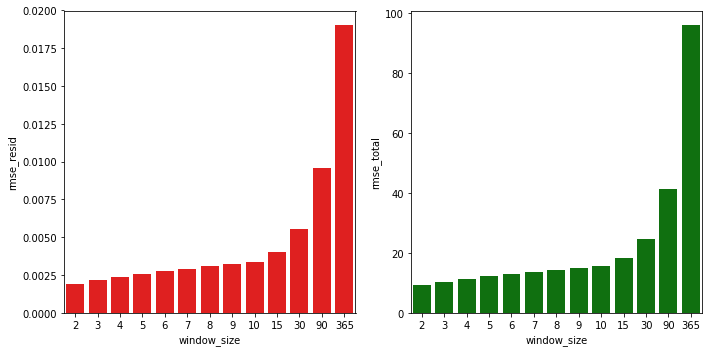

In [61]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 5))
sns.barplot(x="window_size", y="rmse_resid", data=optimization_results, color='r', ax=ax1)
sns.barplot(x="window_size", y="rmse_total", data=optimization_results, color='g', ax=ax2)
f.tight_layout()

In [63]:
print("RMSE resid {}\n and RMSE total {} for window size 2,3,4.".format(rmses_resid[:3], rmses_total[:3]))

RMSE resid [0.001916165938363789, 0.002152914995904894, 0.002368861574381758]
 and RMSE total [9.456319704054117, 10.426646022381444, 11.341209158488079] for window size 2,3,4.


We see that the smaller the window size is, the lower is the error in the prediction.

In [75]:
# Extract prediction with a window size of 2 days
rmse, ma_forecast_resid = moving_average_forecast(sp500_decomposed.ix[frequency:,'log_trend_open_resid'], 2, 
                                                  days_in_advance)
rmse, ma_forecast_trend = moving_average_forecast(sp500_decomposed.ix[frequency:,'log_trend_open_trend'], 2, 
                                                  days_in_advance)
rmse, ma_forecast_season = moving_average_forecast(sp500_decomposed.ix[frequency:,'log_trend_open_season'], 2, 
                                                   days_in_advance)

# Reconvert prediction to original scale
ma_test_pred = exp_scale_and_recompose_time_series(ma_forecast_trend, ma_forecast_season, ma_forecast_resid)

ma_test_true = sp500_decomposed.ix[frequency:,'Open'].reset_index(drop=True)

### 2. Recurrent Neural Network

In [41]:
def build_data_sets(data, seq_len, test_set_size_percentage, valid_set_size_percentage, n_days_in_advance):
    data_raw = data.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-n_days_in_advance,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-n_days_in_advance,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-n_days_in_advance,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


def get_next_batch(batch_size, x_train, y_train, perm_array, index_in_epoch):
 
    start = index_in_epoch
    index_in_epoch += batch_size

    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]], index_in_epoch


def generate_data_sets_and_train_rnn(data, window_sizes, test_set_size_percentage, valid_set_size_percentage, 
                                     n_days_in_advance, cells, n_inputs, n_outputs, n_neurons, 
                                     learning_rate, n_epochs, batch_size):
    rmses_rnn_resid = []
    rmses_rnn_total = []
    y_pred_total = []
    training_times = []
    
    for w_size in window_sizes:
        # Generate data sets
        x_train, y_train, x_valid, y_valid, x_test, y_test = build_data_sets(data, w_size, test_set_size_percentage, 
                                                                         valid_set_size_percentage, n_days_in_advance)
        # Organize training data
        n_steps = w_size-n_days_in_advance 
        perm_array  = np.arange(x_train.shape[0])
        np.random.shuffle(perm_array)
        train_set_size = x_train.shape[0]
        test_set_size = x_test.shape[0]
    
        # train and evaluate a RNN
        y_pred_open_price, y_pred_open_price, rmse_test_residuals, rmse_test_open, training_time = test_trained_recurrent_neural_network(cells, 
                                                         n_steps, n_inputs, n_outputs, n_neurons, perm_array,
                                                         learning_rate, n_epochs, train_set_size, batch_size, 
                                                         x_train, y_train, x_valid, y_valid, x_test, y_test)
        rmses_rnn_resid.append(rmse_test_residuals)
        rmses_rnn_total.append(rmse_test_open)
        y_pred_total.append(y_pred_open_price)
        training_times.append(training_time)
        
    return y_pred_total, y_pred_open_price, rmses_rnn_resid, rmses_rnn_total, training_times


def test_trained_recurrent_neural_network(cells, n_steps, n_inputs, n_outputs, n_neurons, perm_array, learning_rate, 
                                          n_epochs, train_set_size, batch_size, x_train, y_train, x_valid, y_valid, 
                                          x_test, y_test):
    
    # Define initialization parameters of the RNN
    tf.reset_default_graph()

    X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
    y = tf.placeholder(tf.float32, [None, n_outputs])
    
    # Define the type of hidden layers for the recurrent neural network
    if cells == 'elu':
        layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
                  for layer in range(n_layers)]
    elif cells == 'lstm':
        layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, activation=tf.nn.leaky_relu, use_peepholes = True)
                  for layer in range(n_layers)]
    elif cells == 'gru':
        layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
          for layer in range(n_layers)]
        
    multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
    rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
    outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
    loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
    training_op = optimizer.minimize(loss)
    
    # run graph
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        
        # Train the neural network 
        start = timeit.default_timer()

        index_in_epoch = 0
        for iteration in range(int(n_epochs*train_set_size/batch_size)):
            x_batch, y_batch, index_in_epoch_i = get_next_batch(batch_size, x_train, y_train, perm_array, 
                                                              index_in_epoch) # fetch the next training batch 
            index_in_epoch += index_in_epoch_i
            
            sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
            if iteration % int(5*train_set_size/batch_size) == 0:
                mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
                mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
                print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                    iteration*batch_size/train_set_size, mse_train, mse_valid))

        # Predict "Y" with the trained RNN for training, validation and test datasets
        y_train_pred = sess.run(outputs, feed_dict={X: x_train})
        y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
        y_test_pred = sess.run(outputs, feed_dict={X: x_test})
        
        stop = timeit.default_timer()
        training_time = stop - start
        print("The RNN took: {}s to get trained.".format(training_time))
        
        # Calculate RMSE only for the Open price predicted vs true y_test residuals and open stock price
        # residuals in the first dimension y[:,0]
        rmse_test_residuals = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
        
        # reconstruct open price with the exponential of trend y[:,1] * seasonal y[:,2] * residual y[:,0]
        y_test_open_price = exp_scale_and_recompose_time_series(y_test[:,1], y_test[:,2], y_test[:,0])
        y_pred_open_price = exp_scale_and_recompose_time_series(y_test_pred[:,1], y_test_pred[:,2], y_test_pred[:,0])
        rmse_test_open = math.sqrt(mean_squared_error(y_test_open_price, y_pred_open_price))
        
        print("The RMSE between residuals is {} and for the total open stock price is {}.".format(rmse_test_residuals,
                                                                                                  rmse_test_open))
    
    # Return the RMSE for residuals and built open stock price and the predicted values
    return y_pred_open_price, y_test_open_price, rmse_test_residuals, rmse_test_open, training_time

In [42]:
# Basic RNN parameters
n_inputs = 3
n_neurons = 200 
n_outputs = 3
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 

In [43]:
# Build the data sets with the each window size, train RNN and evaluate model
data = sp500_decomposed.loc[frequency:,['log_trend_open_resid','log_trend_open_trend','log_trend_open_season']]

# Number of days in advance to make the prediction
n_days_in_advance = 2

# Split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

In [44]:
# Build sequences of different sizes to consider
# The periods are [2, 3, 7, 10, 15, 30] because it predicts two days in advance
window_sizes = [4, 5, 8, 12, 17, 32]

#### Train and evaluate a elu Recurrent Neural Network

In [45]:
# Define type of RNN as elu
cells = 'elu'
y_pred_open_elu, y_test_open_price_elu, rmse_test_resid_elu, rmse_test_open_elu, training_times_elu = generate_data_sets_and_train_rnn(data, 
                                                         window_sizes, test_set_size_percentage, 
                                                         valid_set_size_percentage, n_days_in_advance, 
                                                         cells, n_inputs, n_outputs, n_neurons, 
                                                         learning_rate, n_epochs, batch_size)

0.00 epochs: MSE train/valid = 2.215920/4.648931
5.00 epochs: MSE train/valid = 0.000177/0.000904
10.00 epochs: MSE train/valid = 0.000076/0.000089
15.00 epochs: MSE train/valid = 0.000022/0.000048
20.00 epochs: MSE train/valid = 0.000036/0.000044
25.00 epochs: MSE train/valid = 0.001582/0.003202
30.00 epochs: MSE train/valid = 0.000033/0.000067
35.00 epochs: MSE train/valid = 0.000147/0.000070
40.00 epochs: MSE train/valid = 0.000281/0.000304
45.00 epochs: MSE train/valid = 0.000171/0.000364
50.00 epochs: MSE train/valid = 0.000120/0.000266
55.00 epochs: MSE train/valid = 0.000022/0.000045
60.00 epochs: MSE train/valid = 0.000027/0.000044
65.00 epochs: MSE train/valid = 0.000024/0.000044
70.00 epochs: MSE train/valid = 0.000038/0.000028
75.00 epochs: MSE train/valid = 0.000035/0.000054
80.00 epochs: MSE train/valid = 0.000027/0.000031
85.00 epochs: MSE train/valid = 0.000030/0.000061
90.00 epochs: MSE train/valid = 0.000068/0.000177
95.00 epochs: MSE train/valid = 0.000019/0.000022
Th

#### Train and evaluate a LSTM Cell RNN

In [46]:
cells = 'lstm'
y_pred_open_lstm, y_test_open_price_lstm, rmse_test_resid_lstm, rmse_test_open_lstm, training_times_lstm = generate_data_sets_and_train_rnn(data, 
                                                         window_sizes, test_set_size_percentage, 
                                                         valid_set_size_percentage, n_days_in_advance, 
                                                         cells, n_inputs, n_outputs, n_neurons, 
                                                         learning_rate, n_epochs, batch_size)

0.00 epochs: MSE train/valid = 9.327305/16.966522
5.00 epochs: MSE train/valid = 0.000872/0.000832
10.00 epochs: MSE train/valid = 0.000176/0.000195
15.00 epochs: MSE train/valid = 0.000054/0.000074
20.00 epochs: MSE train/valid = 0.000032/0.000033
25.00 epochs: MSE train/valid = 0.000252/0.000494
30.00 epochs: MSE train/valid = 0.000026/0.000026
35.00 epochs: MSE train/valid = 0.000036/0.000061
40.00 epochs: MSE train/valid = 0.000117/0.000164
45.00 epochs: MSE train/valid = 0.000192/0.000319
50.00 epochs: MSE train/valid = 0.000039/0.000060
55.00 epochs: MSE train/valid = 0.000037/0.000055
60.00 epochs: MSE train/valid = 0.001117/0.001998
65.00 epochs: MSE train/valid = 0.000021/0.000025
70.00 epochs: MSE train/valid = 0.000052/0.000148
75.00 epochs: MSE train/valid = 0.000023/0.000041
80.00 epochs: MSE train/valid = 0.000047/0.000076
85.00 epochs: MSE train/valid = 0.000030/0.000078
90.00 epochs: MSE train/valid = 0.001672/0.003264
95.00 epochs: MSE train/valid = 0.000017/0.000019
T

#### Train and evaluate a GRU Cell RNN

In [47]:
cells = 'gru'
y_pred_open_gru, y_test_open_price_gru, rmse_test_resid_gru, rmse_test_open_gru, training_times_gru = generate_data_sets_and_train_rnn(data, 
                                                         window_sizes, test_set_size_percentage, 
                                                         valid_set_size_percentage, n_days_in_advance, 
                                                         cells, n_inputs, n_outputs, n_neurons, 
                                                         learning_rate, n_epochs, batch_size)

0.00 epochs: MSE train/valid = 9.093804/16.478827
5.00 epochs: MSE train/valid = 0.000287/0.000357
10.00 epochs: MSE train/valid = 0.000101/0.000119
15.00 epochs: MSE train/valid = 0.000039/0.000064
20.00 epochs: MSE train/valid = 0.000026/0.000040
25.00 epochs: MSE train/valid = 0.000056/0.000110
30.00 epochs: MSE train/valid = 0.000112/0.000202
35.00 epochs: MSE train/valid = 0.000117/0.000180
40.00 epochs: MSE train/valid = 0.000166/0.000295
45.00 epochs: MSE train/valid = 0.000145/0.000427
50.00 epochs: MSE train/valid = 0.000024/0.000057
55.00 epochs: MSE train/valid = 0.000055/0.000040
60.00 epochs: MSE train/valid = 0.000057/0.000118
65.00 epochs: MSE train/valid = 0.000034/0.000073
70.00 epochs: MSE train/valid = 0.000161/0.000426
75.00 epochs: MSE train/valid = 0.000282/0.000585
80.00 epochs: MSE train/valid = 0.000019/0.000052
85.00 epochs: MSE train/valid = 0.000009/0.000045
90.00 epochs: MSE train/valid = 0.000046/0.000090
95.00 epochs: MSE train/valid = 0.000038/0.000083
T

### Evaluate performance of RNN forecast

In [48]:
# Build perforance of each RNN model results data frame
results_elu = pd.DataFrame({'w_size':window_sizes,'rmse_resid':rmse_test_resid_elu,'rmse_total':rmse_test_open_elu,
                            'training_time':training_times_elu})
results_elu['rnn_type'] = 'elu'
results_lstm = pd.DataFrame({'w_size':window_sizes,'rmse_resid':rmse_test_resid_lstm,'rmse_total':rmse_test_open_lstm,
                            'training_time':training_times_lstm})
results_lstm['rnn_type'] = 'lstm'
results_gru = pd.DataFrame({'w_size':window_sizes,'rmse_resid':rmse_test_resid_gru,'rmse_total':rmse_test_open_gru,
                            'training_time':training_times_gru})
results_gru['rnn_type'] = 'gru'
results_performance = pd.concat([results_elu,results_lstm,results_gru])

In [49]:
# Build the open stock price prediction of each RNN model data frame
predictions = []
ypreds = [y_pred_open_elu, y_pred_open_lstm, y_pred_open_gru]
ytests = [y_test_open_price_elu, y_test_open_price_lstm, y_test_open_price_gru]
for i, rnn_type in enumerate(['elu','lstm','gru']):
    y_pred = ypreds[i]
    y_test = ytests[i]

    for j, w_size in enumerate(window_sizes):
        prediction = pd.DataFrame({'y_pred':y_pred[j], 'y_test': y_test[j], 
                               'rnn_type': ['elu']*len(y_pred[j]), 'w_size':[w_size]*len(y_pred[j])})
        prediction['rnn_type'] = rnn_type
        predictions.append(prediction)
predictions = pd.concat(predictions) 

In [50]:
results_performance.to_csv('../data/results_performance.csv', index=False, encoding='utf-8')
predictions.to_csv('../data/predictions.csv', index=False, encoding='utf-8')

#### a) Compare RMSE and training time

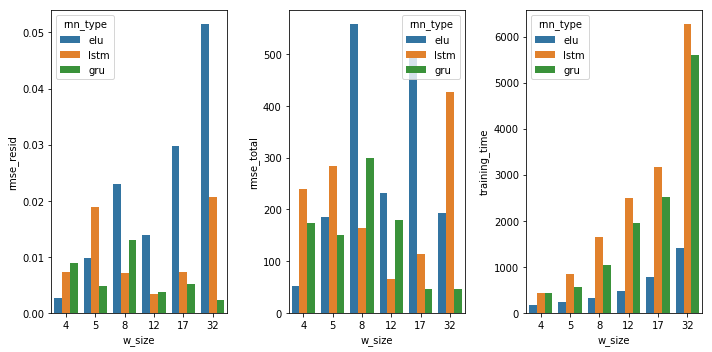

In [51]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(10, 5))
sns.barplot(x="w_size", y="rmse_resid", hue="rnn_type", data=results_performance, ax=ax1)
sns.barplot(x="w_size", y="rmse_total", hue="rnn_type", data=results_performance, ax=ax2)
sns.barplot(x="w_size", y="training_time", hue="rnn_type", data=results_performance, ax=ax3)
f.tight_layout()

In [56]:
# Lowest RMSE
results_performance[results_performance['rmse_resid'] < 0.005]

,rmse_resid,rmse_total,training_time,w_size,rnn_type
0,0.002570,51.587861,164.273080,4,elu
3,0.003281,65.606284,2501.682998,12,lstm
1,0.004732,149.726716,552.963633,5,gru
3,0.003654,179.027270,1950.652560,12,gru
5,0.002374,45.452525,5590.561505,32,gru


#### b) Compare time series prediction

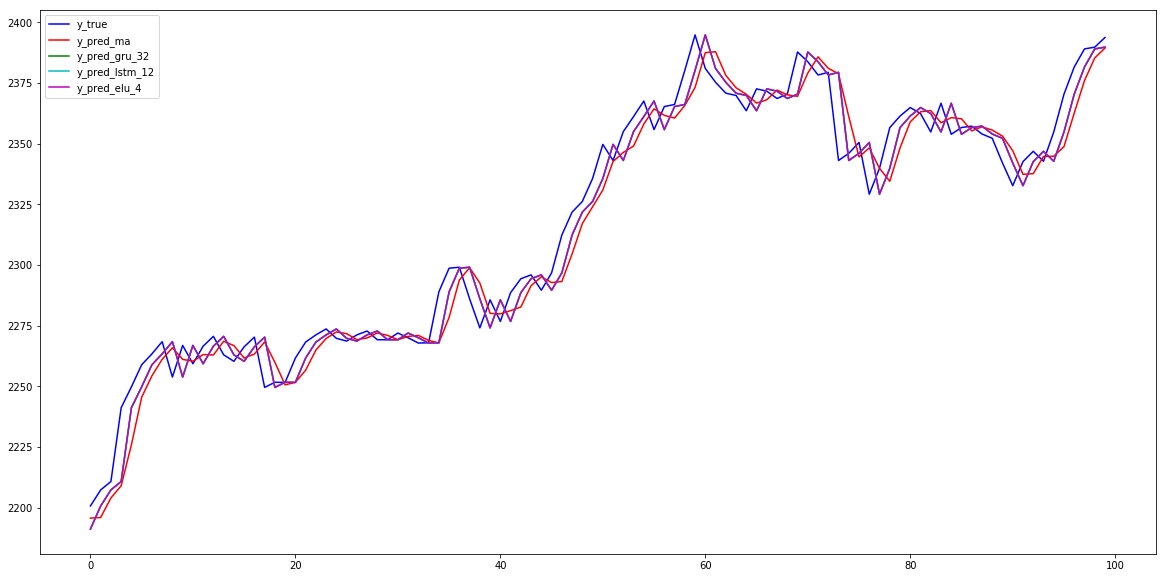

In [97]:
_ = plt.figure(figsize=(20,10))
_ = plt.plot(ma_test_true.tolist()[-100:], color='b')
_ = plt.plot(ma_test_pred.tolist()[-100:], color='r')
_ = plt.plot(predictions[(predictions['rnn_type']=='gru') & 
                         (predictions['w_size']==32)]['y_pred'].tolist()[-100:], color='g')
_ = plt.plot(predictions[(predictions['rnn_type']=='lstm') & 
                         (predictions['w_size']==12)]['y_pred'].tolist()[-100:], color='c')
_ = plt.plot(predictions[(predictions['rnn_type']=='elu') & 
                         (predictions['w_size']==4)]['y_pred'].tolist()[-100:], color='m')
_ = plt.legend(['y_true', 'y_pred_ma', 'y_pred_gru_32', 'y_pred_lstm_12', 'y_pred_elu_4'], loc='upper left')

All predictions from the three type of RNN are indistinguishable.

### Conclusions
    * The moving average method achieves the lowest RMSE with a window size of 2, 3 and 4 days. Long time memory is not a requirement in this case for the time series forecast.
    * RNN with GRU gated units achieves the best prediction comparing all RNN results. However, training time is quite high (~1.5 hours). 
    * Long term memory seems to not be a requirement in this case, the difference on RMSE between the best result with elu and gru units is only of 0.0002 and therefore, if we consider training times, it worths it to use a traditional RNN with a window size of 4 days.
    * Results not provided in this notebook showed than when training the three types of RNN with absolute open stock prices, the RMSE where not better.